In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import importlib
from car_part import CarPartDataset, CarPartConfig, prepare_datasets, split_dataset_balanced
from pathlib import Path
import colorsys
import random
import numpy as np
import maskrcnn.model as modellib
from maskrcnn.model import log
from maskrcnn import visualize
import scipy.io as sio
import json

import matplotlib.pyplot as plt
import imageio
from pycocotools.coco import COCO

In [3]:
part_annotation_path = Path('./dataset/cogito_output_merged_solera.json')
images_path = Path('./dataset/')

In [4]:
ds = COCO(part_annotation_path)

loading annotations into memory...
Done (t=3.71s)
creating index...
index created!


In [45]:
num_categorie = len(ds.cats)
num_immagini = len(ds.imgs)
print(f'Number of segment categories: {num_categorie}')
print(f'Number of images: {num_immagini}')

Number of segment categories: 43
Number of images: 4999


### Number of images for each category

In [36]:
annotations_count = [(ds.cats[cat_id]['name'],len(images)) for cat_id, images in ds.catToImgs.items()]
damages_list = ['scratch', 'dent', 'severe-dent', 'substitution', 'severe_dent']
cats_count = list(filter(lambda x: x[0] not in damages_list, annotations_count))
cats_count = sorted(cats_count, key=lambda x: x[1], reverse=True)
for k in cats_count:
    print('{:<40s}{:>5}'.format(k[0], k[1]))

segment_rear_door_left                   4039
segment_rear_door_right                  4029
segment_car_handle_front                 3188
segment_roofside                         3178
segment_car_handle_back                  2779
segment_front_side                       2716
segment_door_pillar_right                2486
segment_front_bumper                     2451
segment_door_pillar_left                 2411
segment_back_bumper                      2338
segment_windscreen                       2151
segment_left_right                       2007
segment_front_fender_right               1998
segment_left_mirror                      1969
segment_radiator_grill                   1962
segment_front_door_right                 1955
segment_front_fender_left                1935
segment_back_side                        1917
segment_front_door_left                  1917
segment_front_door_window_right          1897
segment_front_door_window_left           1888
segment_wheels_front_right        

## Use the class BalanceDataset to balance the categories of segments contained in training, validation and test images

#### Class BalanceDataset needs the following arguments:

In [130]:
# dictionary to obtain annotations contained in every image
imgToAnns = ds.imgToAnns
# all images Id
all_images_ids = ds.getImgIds()
# dictionary to obtain images containing such segment category
catToImgs = ds.catToImgs

In [61]:
from balancedataset import BalanceDataset

balancer = BalanceDataset(imgToAnns, all_images_ids, catToImgs)
# set the fraction for the three sets: training, validation, test
balancer.set_percentages(train_percentage=0.7, val_percentage=0.1, test_percentage=0.2)

In [114]:
img_id_train, img_id_val, img_id_test = balancer.split_balanced()

Immagini di training: 3499
Immagini di validation: 500
Immagini di test: 1000


In [115]:
balancer.verify_split()

CatId   Tot	train  %      valid  %      test   %     
30     4039	2828  70.0   432    10.7   779    19.3  
31     4029	2821  70.0   427    10.6   781    19.4  
9      3188	2256  70.8   326    10.2   606    19.0  
32     3178	2242  70.5   325    10.2   611    19.2  
1      3166	2213  69.9   286    9.0    667    21.1  
41     2952	2066  70.0   306    10.4   580    19.6  
8      2779	1958  70.5   293    10.5   528    19.0  
26     2716	1911  70.4   265    9.8    540    19.9  
11     2486	1749  70.4   250    10.1   487    19.6  
16     2451	1718  70.1   243    9.9    490    20.0  
10     2411	1684  69.8   248    10.3   479    19.9  
2      2338	1630  69.7   241    10.3   467    20.0  
39     2151	1518  70.6   216    10.0   417    19.4  
28     2007	1408  70.2   211    10.5   388    19.3  
22     1998	1395  69.8   215    10.8   388    19.4  
27     1969	1383  70.2   201    10.2   385    19.6  
29     1962	1364  69.5   208    10.6   390    19.9  
18     1955	1376  70.4   205    10.5   374   

In [113]:
#### another run results
balancer.verify_split()

CatId   Tot	train  %      valid  %      test   %     
30     4039	2836  70.2   435    10.8   768    19.0  
31     4029	2814  69.8   420    10.4   795    19.7  
9      3188	2232  70.0   335    10.5   621    19.5  
32     3178	2214  69.7   341    10.7   623    19.6  
1      3166	2216  70.0   316    10.0   634    20.0  
41     2952	2061  69.8   295    10.0   596    20.2  
8      2779	1944  70.0   306    11.0   529    19.0  
26     2716	1912  70.4   265    9.8    539    19.8  
11     2486	1744  70.2   254    10.2   488    19.6  
16     2451	1726  70.4   248    10.1   477    19.5  
10     2411	1695  70.3   260    10.8   456    18.9  
2      2338	1639  70.1   244    10.4   455    19.5  
39     2151	1507  70.1   225    10.5   419    19.5  
28     2007	1414  70.5   202    10.1   391    19.5  
22     1998	1394  69.8   196    9.8    408    20.4  
27     1969	1374  69.8   205    10.4   390    19.8  
29     1962	1372  69.9   204    10.4   386    19.7  
18     1955	1373  70.2   194    9.9    388   

### Look into images in training set

In [135]:
dataset_train = CarPartDataset()
id_to_category = dataset_train.load_dataset(part_annotation_path, images_path, img_id_train)
dataset_train.prepare()

num_img_not_it_annotations 7
Images loaded: 3499


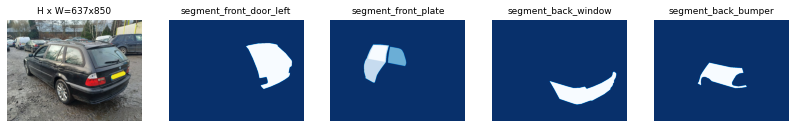

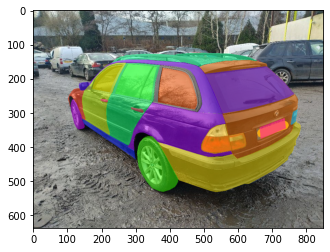

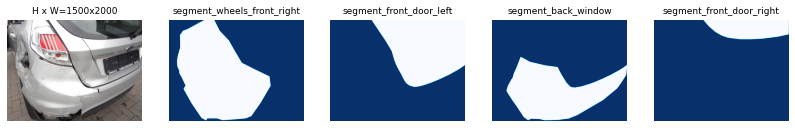

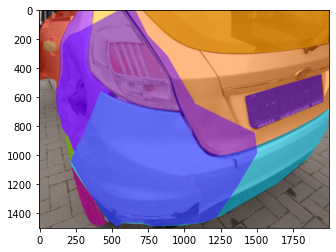

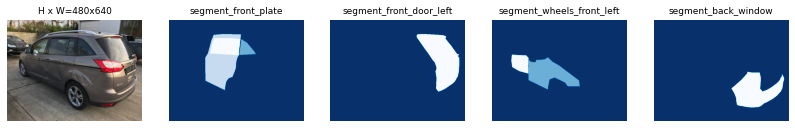

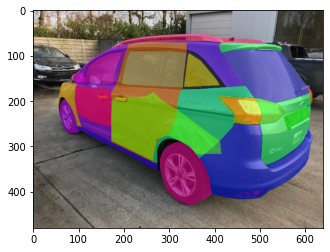

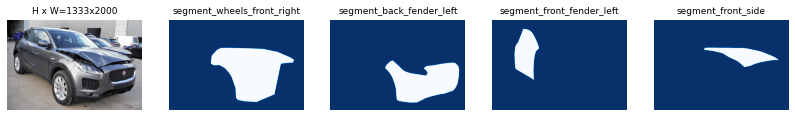

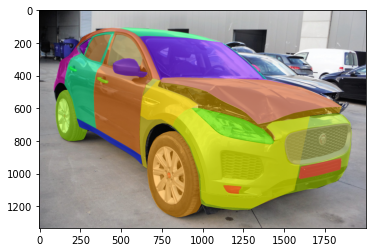

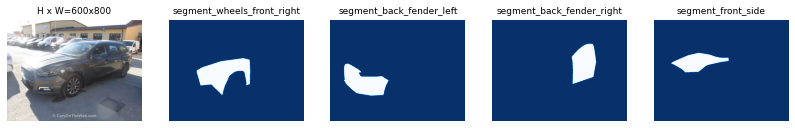

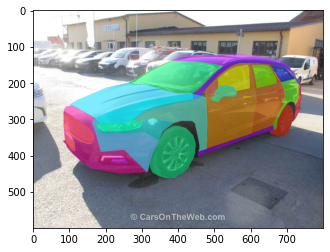

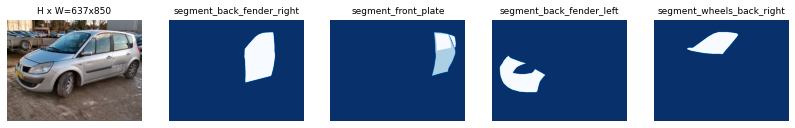

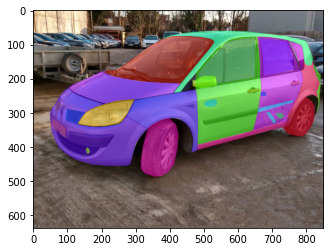

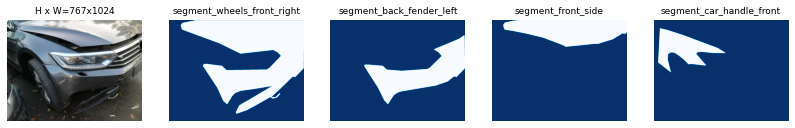

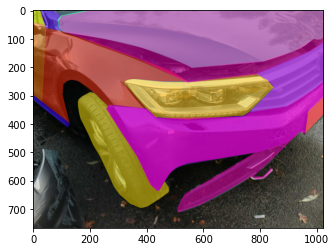

In [136]:
colors = visualize.generate_colormap(40, scaled=False)
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 7)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    img_copy = image.copy()
    for l in range(mask.shape[-1]):
        img_copy = visualize.apply_mask(img_copy, mask[:,:,l], colors[l])
    plt.imshow(img_copy)

In [ ]:

dataset_val = CarPartDataset()
dataset_val.load_dataset(part_annotation_path, images_path, img_id_val)
dataset_val.prepare()

dataset_test = CarPartDataset()
dataset_test.load_dataset(part_annotation_path, images_path, img_id_test)
dataset_test.prepare()